# Neural Network Implementation

In [219]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Deep Learning Libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler

# Set up plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

# Check if CUDA is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
print("Libraries imported successfully!")


Using device: cpu
Libraries imported successfully!


In [220]:
# Define paths
processed_data_dir = Path('../data/processed')

# List all processed files
processed_files = list(processed_data_dir.glob('*_processed.csv'))
print(f"Found {len(processed_files)} processed data files:")
for file in processed_files:
    print(f"  - {file.name}")

# Load all data into a dictionary
data_dict = {}
for file_path in processed_files:
    data_type = file_path.stem.replace('_processed', '')
    print(f"\nLoading {data_type}...")
    
    try:
        df = pd.read_csv(file_path)
        # Convert datetime column
        df['datetime'] = pd.to_datetime(df['datetime'])
        data_dict[data_type] = df
        print(f"  ✓ Loaded {len(df)} records")
        print(f"  ✓ Date range: {df['datetime'].min()} to {df['datetime'].max()}")
        print(f"  ✓ Columns: {list(df.columns)}")
    except Exception as e:
        print(f"  ✗ Error loading {data_type}: {e}")

print(f"\nSuccessfully loaded {len(data_dict)} datasets")


Found 4 processed data files:
  - water_height_processed.csv
  - flow_rate_processed.csv
  - wind_direction_processed.csv
  - current_direction_processed.csv

Loading water_height...
  ✓ Loaded 26892 records
  ✓ Date range: 2025-01-01 00:00:00 to 2025-07-02 10:30:00
  ✓ Columns: ['datetime', 'datetime_unix', 'NUMERIEKEWAARDE', 'X', 'Y']

Loading flow_rate...
  ✓ Loaded 26264 records
  ✓ Date range: 2025-01-01 00:00:00 to 2025-07-02 10:30:00
  ✓ Columns: ['datetime', 'datetime_unix', 'NUMERIEKEWAARDE', 'X', 'Y']

Loading wind_direction...
  ✓ Loaded 26171 records
  ✓ Date range: 2025-01-01 00:00:00 to 2025-07-02 10:30:00
  ✓ Columns: ['datetime', 'datetime_unix', 'NUMERIEKEWAARDE', 'X', 'Y']

Loading current_direction...
  ✓ Loaded 26175 records
  ✓ Date range: 2025-01-01 00:00:00 to 2025-07-02 10:30:00
  ✓ Columns: ['datetime', 'datetime_unix', 'NUMERIEKEWAARDE', 'X', 'Y']

Successfully loaded 4 datasets


In [221]:
def prepare_current_direction_features(data_dict, sequence_length=24):
    """
    Prepare features and targets for current direction prediction.
    
    Args:
        data_dict: Dictionary of datasets
        sequence_length: Number of time steps to use as input
        
    Returns:
        Tuple of (features, targets, feature_columns, target_column)
    """
    print("Preparing features for current direction prediction...")
    
    # Merge all datasets on datetime
    merged_data = None
    for data_type, df in data_dict.items():
        df_copy = df.copy()
        # Rename NUMERIEKEWAARDE to avoid conflicts
        df_copy = df_copy.rename(columns={'NUMERIEKEWAARDE': f'{data_type}_value'})
        
        if merged_data is None:
            merged_data = df_copy[['datetime', f'{data_type}_value']]
        else:
            merged_data = merged_data.merge(
                df_copy[['datetime', f'{data_type}_value']], 
                on='datetime', how='inner'
            )
    
    # Sort by datetime
    merged_data = merged_data.sort_values('datetime').reset_index(drop=True)
    
    # Create time-based features
    merged_data['hour'] = merged_data['datetime'].dt.hour
    merged_data['day_of_week'] = merged_data['datetime'].dt.dayofweek
    merged_data['month'] = merged_data['datetime'].dt.month
    
    # Normalize time features
    merged_data['hour_norm'] = merged_data['hour'] / 24.0
    merged_data['day_of_week_norm'] = merged_data['day_of_week'] / 7.0
    merged_data['month_norm'] = merged_data['month'] / 12.0
    
    # Select feature columns (all variables except current_direction)
    feature_columns = [col for col in merged_data.columns if col.endswith('_value') or col.endswith('_norm')]
    target_column = 'current_direction_value'
    
    # Remove target from features
    if target_column in feature_columns:
        feature_columns.remove(target_column)
    
    # Prepare features and targets
    features = merged_data[feature_columns].values
    targets = merged_data[target_column].values
    
    print(f"  ✓ Features shape: {features.shape}")
    print(f"  ✓ Targets shape: {targets.shape}")
    print(f"  ✓ Feature columns: {feature_columns}")
    print(f"  ✓ Target column: {target_column}")
    
    return features, targets, feature_columns, target_column

# Prepare data for current direction prediction
features, targets, feature_columns, target_column = prepare_current_direction_features(data_dict, sequence_length=24)


Preparing features for current direction prediction...
  ✓ Features shape: (26169, 6)
  ✓ Targets shape: (26169,)
  ✓ Feature columns: ['water_height_value', 'flow_rate_value', 'wind_direction_value', 'hour_norm', 'day_of_week_norm', 'month_norm']
  ✓ Target column: current_direction_value


In [222]:
class CrossCurrentDataset(Dataset):
    """Custom Dataset for cross-current time series data."""
    
    def __init__(self, data, targets, sequence_length=24):
        """
        Initialize the dataset.
        
        Args:
            data: Input features (n_samples, n_features)
            targets: Target values (n_samples, n_targets)
            sequence_length: Number of time steps to use as input
        """
        self.data = torch.FloatTensor(data)
        self.targets = torch.FloatTensor(targets)
        self.sequence_length = sequence_length
        
    def __len__(self):
        return len(self.data) - self.sequence_length
        
    def __getitem__(self, idx):
        # Get sequence of input data
        x = self.data[idx:idx + self.sequence_length]
        # Get target (next value after sequence)
        y = self.targets[idx + self.sequence_length]
        return x, y


In [223]:
class LSTMPredictor(nn.Module):
    """LSTM-based neural network for current direction prediction."""
    
    def __init__(self, input_size, hidden_size=128, num_layers=2, output_size=1, dropout=0.2):
        """
        Initialize the LSTM model.
        
        Args:
            input_size: Number of input features
            hidden_size: Number of hidden units in LSTM layers
            num_layers: Number of LSTM layers
            output_size: Number of output features
            dropout: Dropout rate
        """
        super(LSTMPredictor, self).__init__()
        
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        # LSTM layers
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0
        )
        
        # Fully connected layers
        self.fc_layers = nn.Sequential(
            nn.Linear(hidden_size, 64),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(32, output_size)
        )
        
    def forward(self, x):
        """
        Forward pass through the network.
        
        Args:
            x: Input tensor of shape (batch_size, sequence_length, input_size)
            
        Returns:
            Output tensor of shape (batch_size, output_size)
        """
        # Initialize hidden state
        batch_size = x.size(0)
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(x.device)
        
        # LSTM forward pass
        lstm_out, _ = self.lstm(x, (h0, c0))
        
        # Take the last output from the sequence
        lstm_out = lstm_out[:, -1, :]
        
        # Pass through fully connected layers
        output = self.fc_layers(lstm_out)
        
        return output


In [224]:
def create_datasets(features, targets, train_split=0.7, val_split=0.15, sequence_length=24):
    """
    Create train, validation, and test datasets.
    
    Args:
        features: Input features
        targets: Target values
        train_split: Fraction of data for training
        val_split: Fraction of data for validation
        sequence_length: Number of time steps for sequences
        
    Returns:
        Tuple of (train_dataset, val_dataset, test_dataset)
    """
    print("Creating datasets...")
    
    # Calculate split indices
    n_samples = len(features) - sequence_length
    train_end = int(n_samples * train_split)
    val_end = int(n_samples * (train_split + val_split))
    
    # Create datasets
    train_dataset = CrossCurrentDataset(
        features[:train_end + sequence_length], 
        targets[:train_end + sequence_length], 
        sequence_length
    )
    
    val_dataset = CrossCurrentDataset(
        features[train_end:val_end + sequence_length], 
        targets[train_end:val_end + sequence_length], 
        sequence_length
    )
    
    test_dataset = CrossCurrentDataset(
        features[val_end:], 
        targets[val_end:], 
        sequence_length
    )
    
    print(f"  ✓ Train samples: {len(train_dataset)}")
    print(f"  ✓ Validation samples: {len(val_dataset)}")
    print(f"  ✓ Test samples: {len(test_dataset)}")
    
    return train_dataset, val_dataset, test_dataset

# Create datasets
sequence_length = 24
train_dataset, val_dataset, test_dataset = create_datasets(features, targets, sequence_length=sequence_length)


Creating datasets...
  ✓ Train samples: 18301
  ✓ Validation samples: 3922
  ✓ Test samples: 3922


In [225]:
def train_model(train_dataset, val_dataset, model_config=None):
    """
    Train the neural network model.
    
    Args:
        train_dataset: Training dataset
        val_dataset: Validation dataset
        model_config: Model configuration parameters
        
    Returns:
        Tuple of (model, training_history)
    """
    if model_config is None:
        model_config = {
            'hidden_size': 128,
            'num_layers': 2,
            'dropout': 0.2,
            'learning_rate': 0.001,
            'batch_size': 32,
            'epochs': 100,
            'patience': 10
        }
    
    print("Training neural network model for current direction prediction...")
    print(f"Model config: {model_config}")
    
    # Create data loaders
    train_loader = DataLoader(train_dataset, batch_size=model_config['batch_size'], shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=model_config['batch_size'], shuffle=False)
    
    # Initialize model
    input_size = train_dataset.data.shape[1]
    model = LSTMPredictor(
        input_size=input_size,
        hidden_size=model_config['hidden_size'],
        num_layers=model_config['num_layers'],
        output_size=1,
        dropout=model_config['dropout']
    ).to(device)
    
    # Loss function and optimizer
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=model_config['learning_rate'])
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5, factor=0.5)
    
    # Training history
    train_losses = []
    val_losses = []
    best_val_loss = float('inf')
    patience_counter = 0
    
    # Training loop
    for epoch in range(model_config['epochs']):
        # Training phase
        model.train()
        train_loss = 0.0
        for batch_x, batch_y in train_loader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)
            
            optimizer.zero_grad()
            outputs = model(batch_x)
            loss = criterion(outputs.squeeze(), batch_y)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
        
        train_loss /= len(train_loader)
        train_losses.append(train_loss)
        
        # Validation phase
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for batch_x, batch_y in val_loader:
                batch_x, batch_y = batch_x.to(device), batch_y.to(device)
                outputs = model(batch_x)
                loss = criterion(outputs.squeeze(), batch_y)
                val_loss += loss.item()
        
        val_loss /= len(val_loader)
        val_losses.append(val_loss)
        
        # Learning rate scheduling
        scheduler.step(val_loss)
        
        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            # Save best model
            torch.save(model.state_dict(), '../models/best_current_direction_model.pth')
        else:
            patience_counter += 1
        
        # Print progress
        if (epoch + 1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{model_config["epochs"]}], '
                  f'Train Loss: {train_loss:.6f}, '
                  f'Val Loss: {val_loss:.6f}, '
                  f'LR: {optimizer.param_groups[0]["lr"]:.6f}')
        
        # Early stopping
        if patience_counter >= model_config['patience']:
            print(f'Early stopping at epoch {epoch+1}')
            break
    
    # Load best model
    model.load_state_dict(torch.load('../models/best_current_direction_model.pth'))
    
    return model, {'train_losses': train_losses, 'val_losses': val_losses}


In [ ]:
# Model configuration for current direction prediction
model_config = {
    'hidden_size': 16,
    'num_layers': 8,
    'dropout': 0.5,
    'learning_rate': 0.01,
    'batch_size': 32,
    'epochs': 50,
    'patience': 20
}

# Train the model
model, history = train_model(train_dataset, val_dataset, model_config)


Training neural network model for current direction prediction...
Model config: {'hidden_size': 16, 'num_layers': 8, 'dropout': 0.5, 'learning_rate': 0.01, 'batch_size': 32, 'epochs': 50, 'patience': 20}


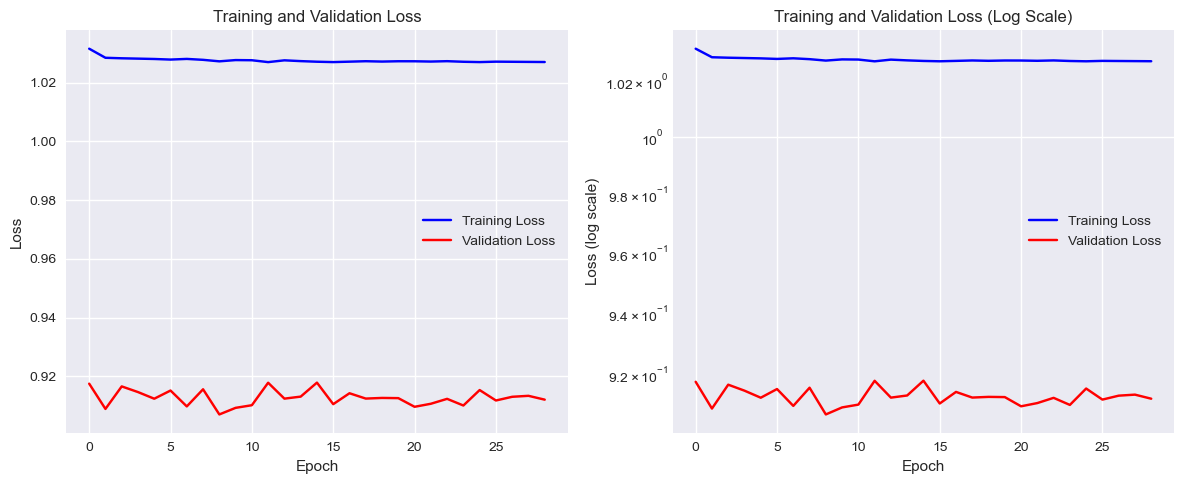

In [ ]:
def plot_training_history(history):
    """Plot training and validation loss."""
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(history['train_losses'], label='Training Loss', color='blue')
    plt.plot(history['val_losses'], label='Validation Loss', color='red')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    
    plt.subplot(1, 2, 2)
    plt.semilogy(history['train_losses'], label='Training Loss', color='blue')
    plt.semilogy(history['val_losses'], label='Validation Loss', color='red')
    plt.title('Training and Validation Loss (Log Scale)')
    plt.xlabel('Epoch')
    plt.ylabel('Loss (log scale)')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()

# Plot training history
plot_training_history(history)


In [ ]:
def evaluate_model(model, test_dataset, scaler=None):
    """
    Evaluate the model on test data.
    
    Args:
        model: Trained model
        test_dataset: Test dataset
        scaler: Optional scaler for denormalization
        
    Returns:
        Dictionary with evaluation metrics
    """
    model.eval()
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
    
    predictions = []
    actuals = []
    
    with torch.no_grad():
        for batch_x, batch_y in test_loader:
            batch_x = batch_x.to(device)
            outputs = model(batch_x)
            predictions.extend(outputs.cpu().numpy().flatten())
            actuals.extend(batch_y.numpy())
    
    predictions = np.array(predictions)
    actuals = np.array(actuals)
    
    # Calculate metrics
    mse = mean_squared_error(actuals, predictions)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(actuals, predictions)
    r2 = r2_score(actuals, predictions)
    
    metrics = {
        'MSE': mse,
        'RMSE': rmse,
        'MAE': mae,
        'R2': r2
    }
    
    print("Current Direction Model Performance:")
    for metric, value in metrics.items():
        print(f"  {metric}: {value:.6f}")
    
    return metrics, predictions, actuals


In [ ]:
# Evaluate on test set
metrics, predictions, actuals = evaluate_model(model, test_dataset)


Current Direction Model Performance:
  MSE: 0.959075
  RMSE: 0.979324
  MAE: 0.852066
  R2: -0.000132


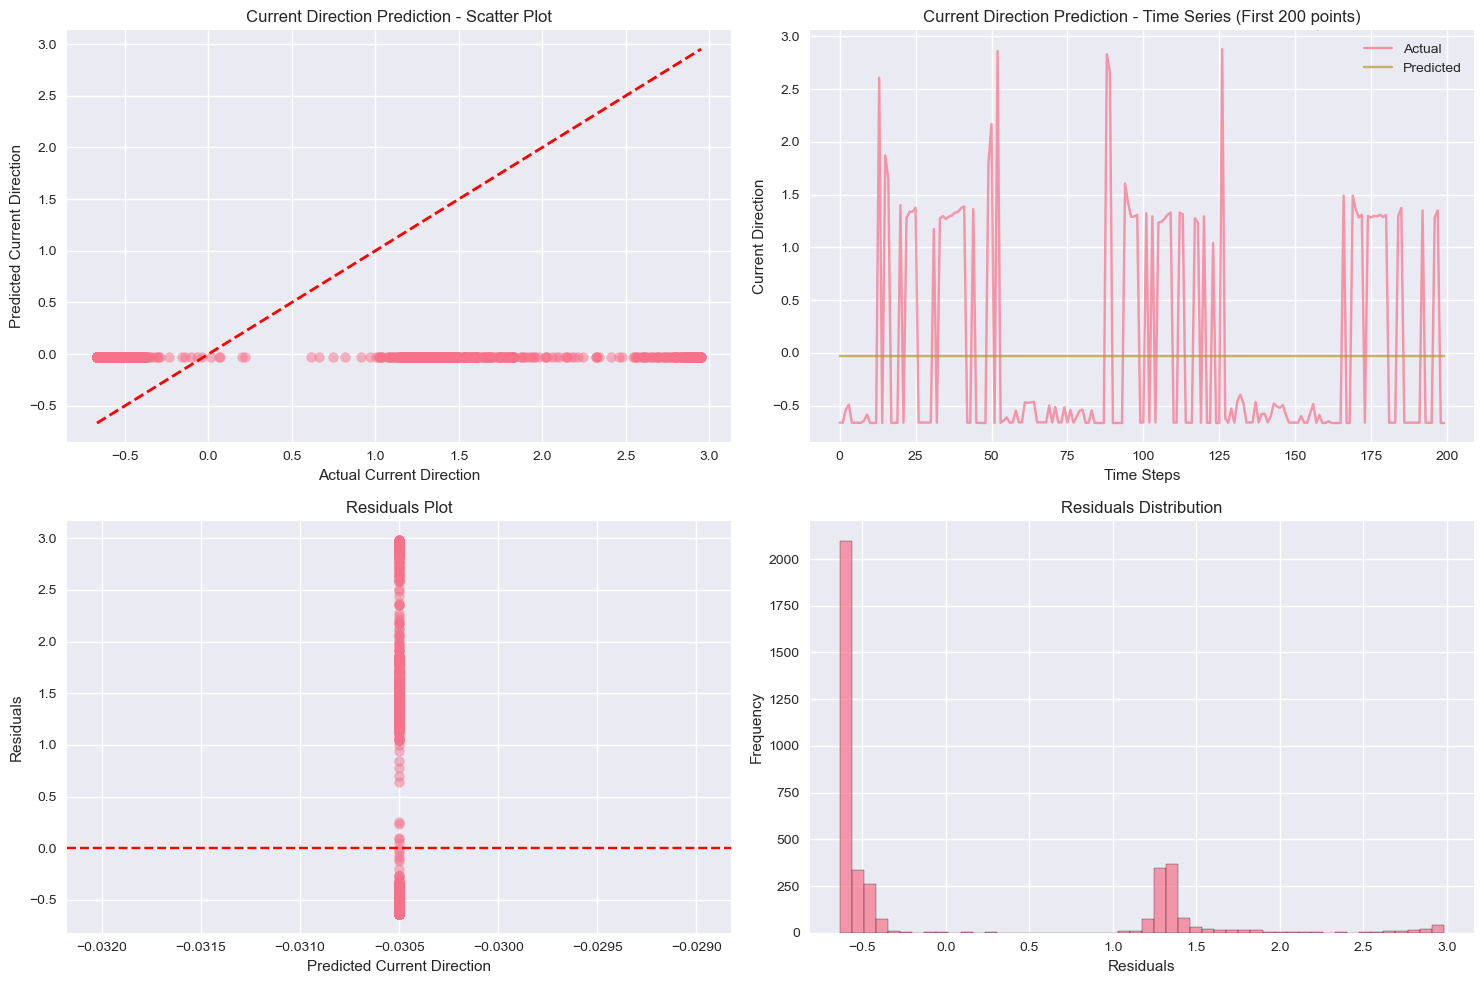

In [ ]:
def plot_predictions(actuals, predictions, title="Current Direction Predictions vs Actual"):
    """Plot predictions against actual values."""
    plt.figure(figsize=(15, 10))
    
    # Scatter plot
    plt.subplot(2, 2, 1)
    plt.scatter(actuals, predictions, alpha=0.5)
    plt.plot([actuals.min(), actuals.max()], [actuals.min(), actuals.max()], 'r--', lw=2)
    plt.xlabel('Actual Current Direction')
    plt.ylabel('Predicted Current Direction')
    plt.title(f'{title} - Scatter Plot')
    plt.grid(True)
    
    # Time series plot (first 200 points)
    plt.subplot(2, 2, 2)
    n_points = min(200, len(actuals))
    plt.plot(actuals[:n_points], label='Actual', alpha=0.7)
    plt.plot(predictions[:n_points], label='Predicted', alpha=0.7)
    plt.xlabel('Time Steps')
    plt.ylabel('Current Direction')
    plt.title(f'{title} - Time Series (First {n_points} points)')
    plt.legend()
    plt.grid(True)
    
    # Residuals plot
    plt.subplot(2, 2, 3)
    residuals = actuals - predictions
    plt.scatter(predictions, residuals, alpha=0.5)
    plt.axhline(y=0, color='r', linestyle='--')
    plt.xlabel('Predicted Current Direction')
    plt.ylabel('Residuals')
    plt.title('Residuals Plot')
    plt.grid(True)
    
    # Residuals histogram
    plt.subplot(2, 2, 4)
    plt.hist(residuals, bins=50, alpha=0.7, edgecolor='black')
    plt.xlabel('Residuals')
    plt.ylabel('Frequency')
    plt.title('Residuals Distribution')
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()

# Plot predictions
plot_predictions(actuals, predictions, "Current Direction Prediction")


Analyzing feature importance for current direction prediction...
Current Direction Model Performance:
  MSE: 0.959075
  RMSE: 0.979324
  MAE: 0.852066
  R2: -0.000132
Testing feature: water_height_value
Current Direction Model Performance:
  MSE: 0.959075
  RMSE: 0.979324
  MAE: 0.852066
  R2: -0.000132
Testing feature: flow_rate_value
Current Direction Model Performance:
  MSE: 0.959075
  RMSE: 0.979324
  MAE: 0.852066
  R2: -0.000132
Testing feature: wind_direction_value
Current Direction Model Performance:
  MSE: 0.959075
  RMSE: 0.979324
  MAE: 0.852066
  R2: -0.000132
Testing feature: hour_norm
Current Direction Model Performance:
  MSE: 0.959075
  RMSE: 0.979324
  MAE: 0.852066
  R2: -0.000132
Testing feature: day_of_week_norm
Current Direction Model Performance:
  MSE: 0.959075
  RMSE: 0.979324
  MAE: 0.852066
  R2: -0.000132
Testing feature: month_norm
Current Direction Model Performance:
  MSE: 0.959075
  RMSE: 0.979324
  MAE: 0.852066
  R2: -0.000132


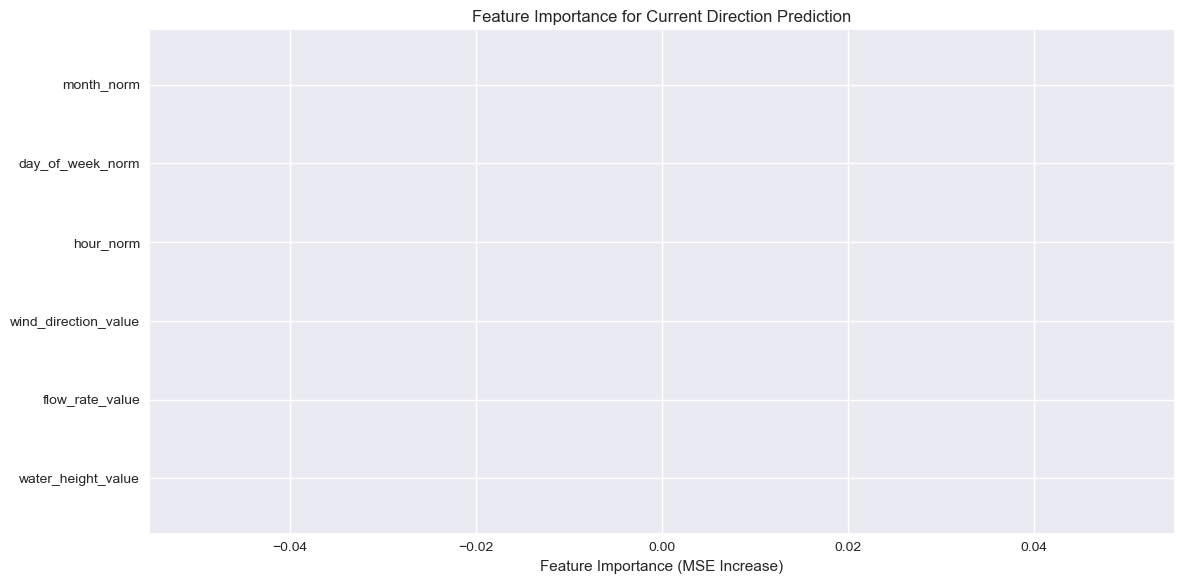

In [ ]:
def analyze_feature_importance(model, feature_columns, test_dataset):
    """Analyze feature importance using permutation importance."""
    print("Analyzing feature importance for current direction prediction...")
    
    # Get baseline performance
    baseline_metrics, _, _ = evaluate_model(model, test_dataset)
    baseline_mse = baseline_metrics['MSE']
    
    importance_scores = {}
    
    # Test each feature
    for i, feature_name in enumerate(feature_columns):
        print(f"Testing feature: {feature_name}")
        
        # Create modified test dataset with shuffled feature
        modified_data = test_dataset.data.clone()
        modified_data[:, i] = torch.randn_like(modified_data[:, i])
        
        modified_dataset = CrossCurrentDataset(
            modified_data.numpy(), 
            test_dataset.targets.numpy(), 
            test_dataset.sequence_length
        )
        
        # Evaluate with modified feature
        modified_metrics, _, _ = evaluate_model(model, modified_dataset)
        modified_mse = modified_metrics['MSE']
        
        # Importance is the increase in MSE
        importance = modified_mse - baseline_mse
        importance_scores[feature_name] = importance
    
    # Sort features by importance
    sorted_features = sorted(importance_scores.items(), key=lambda x: x[1], reverse=True)
    
    # Plot feature importance
    plt.figure(figsize=(12, 6))
    feature_names = [f[0] for f in sorted_features]
    importance_values = [f[1] for f in sorted_features]
    
    plt.barh(range(len(feature_names)), importance_values)
    plt.yticks(range(len(feature_names)), feature_names)
    plt.xlabel('Feature Importance (MSE Increase)')
    plt.title('Feature Importance for Current Direction Prediction')
    plt.grid(True, axis='x')
    plt.tight_layout()
    plt.show()
    
    return importance_scores

# Analyze feature importance
importance_scores = analyze_feature_importance(model, feature_columns, test_dataset)


In [ ]:
torch.save({
    'model_state_dict': model.state_dict(),
    'model_config': model_config,
    'feature_columns': feature_columns,
    'target_column': target_column,
    'sequence_length': sequence_length,
    'metrics': metrics
}, '../models/current_direction_lstm_model.pth')

print("Current direction model saved successfully!")

# Save results to CSV
# results_df = pd.DataFrame({
#     'actual_current_direction': actuals,
#     'predicted_current_direction': predictions,
#     'residuals': actuals - predictions
# })

# results_df.to_csv('current_direction_predictions.csv', index=False)
# print("Current direction results saved to current_direction_predictions.csv")


Current direction model saved successfully!


In [ ]:
print("="*60)
print("CURRENT DIRECTION LSTM NEURAL NETWORK SUMMARY")
print("="*60)
print(f"Target Variable: {target_column}")
print(f"Number of Features: {len(feature_columns)}")
print(f"Feature Variables: {feature_columns}")
print(f"Sequence Length: {sequence_length} (4 hours with 10-minute intervals)")
print(f"Training Samples: {len(train_dataset)}")
print(f"Validation Samples: {len(val_dataset)}")
print(f"Test Samples: {len(test_dataset)}")
print("\nModel Performance:")
for metric, value in metrics.items():
    print(f"  {metric}: {value:.6f}")
print("\nTop 5 Most Important Features:")
sorted_features = sorted(importance_scores.items(), key=lambda x: x[1], reverse=True)
for i, (feature, importance) in enumerate(sorted_features[:5]):
    print(f"  {i+1}. {feature}: {importance:.6f}")
print("\nModel Architecture:")
print(f"  LSTM Layers: {model_config['num_layers']}")
print(f"  Hidden Size: {model_config['hidden_size']}")
print(f"  Dropout: {model_config['dropout']}")
print(f"  Learning Rate: {model_config['learning_rate']}")
print("="*60)

CURRENT DIRECTION LSTM NEURAL NETWORK SUMMARY
Target Variable: current_direction_value
Number of Features: 6
Feature Variables: ['water_height_value', 'flow_rate_value', 'wind_direction_value', 'hour_norm', 'day_of_week_norm', 'month_norm']
Sequence Length: 24 (4 hours with 10-minute intervals)
Training Samples: 18301
Validation Samples: 3922
Test Samples: 3922

Model Performance:
  MSE: 0.959075
  RMSE: 0.979324
  MAE: 0.852066
  R2: -0.000132

Top 5 Most Important Features:
  1. water_height_value: 0.000000
  2. flow_rate_value: 0.000000
  3. wind_direction_value: 0.000000
  4. hour_norm: 0.000000
  5. day_of_week_norm: 0.000000

Model Architecture:
  LSTM Layers: 4
  Hidden Size: 32
  Dropout: 0.7
  Learning Rate: 0.01
